In [156]:
import numpy as np
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import pandas as pd
from common_utils import compute_metrics
compas_data = CompasDataset()
from aif360.metrics import BinaryLabelDatasetMetric, MDSSClassificationMetric
from aif360.detectors import bias_scan


In [157]:
# Convert to Pandas DataFrame
compas_df = pd.DataFrame(data=compas_data.features, columns=compas_data.feature_names)

# Print 
compas_df.head()



,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,age_cat=25 - 45,age_cat=Greater than 45,age_cat=Less than 25,...,c_charge_desc=Video Voyeur-<24Y on Child >16,c_charge_desc=Viol Injunct Domestic Violence,c_charge_desc=Viol Injunction Protect Dom Vi,c_charge_desc=Viol Pretrial Release Dom Viol,c_charge_desc=Viol Prot Injunc Repeat Viol,c_charge_desc=Violation License Restrictions,c_charge_desc=Violation Of Boater Safety Id,c_charge_desc=Violation of Injunction Order/Stalking/Cyberstalking,c_charge_desc=Voyeurism,c_charge_desc=arrest case no charge
0,0.0,69.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,34.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,24.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,44.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,41.0,1.0,0.0,0.0,0.0,14.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [158]:
# Selecting relevant columns for the fairness analysis
relevant_columns = ['sex', 'age', 'race']

# Creating a new dataframe with selected columns
compas_selected = compas_df[relevant_columns]

# Checking for missing values
missing_values = compas_selected.isnull().sum()

# Displaying the new dataframe and missing values information
compas_selected.head()


,sex,age,race
0,0.0,69.0,0.0
1,0.0,34.0,0.0
2,0.0,24.0,0.0
3,0.0,44.0,0.0
4,0.0,41.0,1.0


In [159]:
 missing_values

sex     0
age     0
race    0
dtype: int64

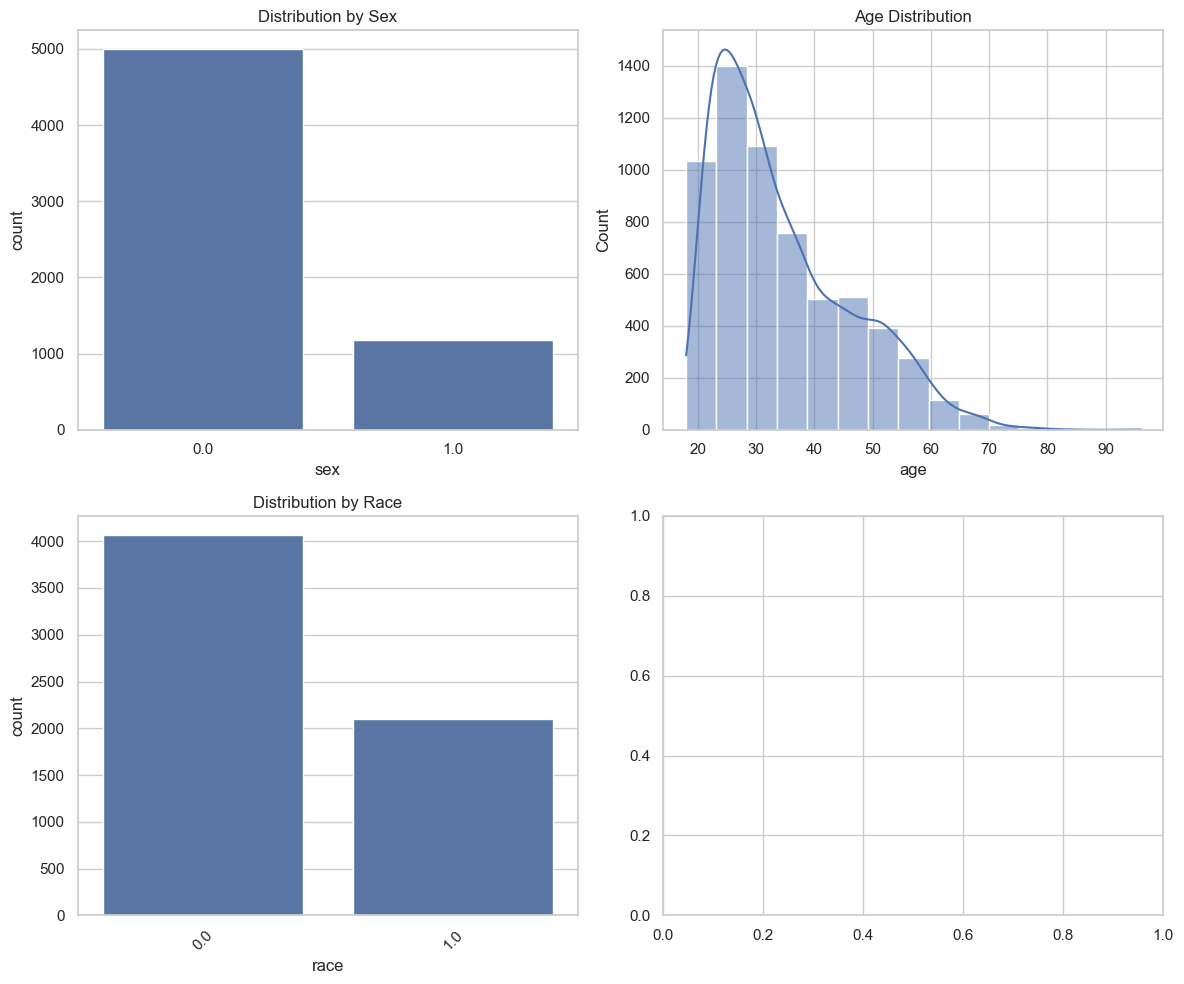

In [160]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")

# Creating plots to show distribution of protected attributes and outcomes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Sex distribution
sns.countplot(x='sex', data=compas_selected, ax=axes[0, 0])
axes[0, 0].set_title('Distribution by Sex')

# Age distribution
sns.histplot(compas_selected['age'], bins=15, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Age Distribution')

# Race distribution
sns.countplot(x='race', data=compas_selected, ax=axes[1, 0])
axes[1, 0].set_title('Distribution by Race')
axes[1, 0].tick_params(axis='x', rotation=45)


# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()


## Consider race to be the protected attribute, fix the bias using the reweighing preprocessing technique, and measure the bias assuming sex is the protected attribute.

In [161]:
%matplotlib inline
# Load all necessary packages
# import sys
# sys.path.append("../")
import numpy as np
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import pandas as pd
from common_utils import compute_metrics
# load the data
compas_data = load_preproc_data_compas()

np.random.seed(1)

In [162]:

privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]


# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_test = compas_data.split([0.5], shuffle=True)

# print
print("#### Training Dataset shape")
print(dataset_orig_train.features.shape)
print("#### Favorable and unfavorable labels")
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
print("#### Protected attribute names")
print(dataset_orig_train.protected_attribute_names)
print("#### Privileged and unprivileged protected attribute values")
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)



#### Training Dataset shape
(2639, 10)
#### Favorable and unfavorable labels
0.0 1.0
#### Protected attribute names
['sex', 'race']
#### Privileged and unprivileged protected attribute values
[array([1.]), array([1.])] [array([0.]), array([0.])]


In [163]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.106802


### Step 4 Mitigate bias by transforming the original dataset
The previous step showed that the privileged group was getting 13% more positive outcomes in the training dataset

In [164]:
RW = Reweighing(unprivileged_groups=privileged_groups, privileged_groups=unprivileged_groups)
dataset_transf_train = RW.fit_transform(dataset_orig_train)

In [165]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


#### Train with and transform the original training data

In [166]:

# simple model LogisticRegression
model = LogisticRegression()
model.fit(dataset_transf_train.features, dataset_transf_train.labels.ravel(),
          sample_weight=dataset_transf_train.instance_weights)

dataset_orig_test_pred = dataset_orig_test.copy()
dataset_orig_test_pred.labels = model.predict(dataset_orig_test.features)


metric_test_sex = BinaryLabelDatasetMetric(dataset_orig_test_pred, 
                                           unprivileged_groups=[{'sex': 0}],
                                           privileged_groups=[{'sex': 1}])
# 
print("Difference in Mean Outcomes (Sex):", metric_test_sex.mean_difference())
print("Disparate Impact (Sex):", metric_test_sex.disparate_impact())


Difference in Mean Outcomes (Sex): -0.24361508849524582
Disparate Impact (Sex): 0.6928862418217828


In [167]:

#

## Consider sex to be the protected attribute, fix the bias using the reweighing preprocessing technique, and measure the bias assuming race is the protected attribute.

In [168]:
from aif360.algorithms.preprocessing import Reweighing
from sklearn.linear_model import LogisticRegression
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric


RW = Reweighing(unprivileged_groups=[{'sex': 0}], privileged_groups=[{'sex': 1}])
dataset_transf_train = RW.fit_transform(dataset_orig_train)


model = LogisticRegression()
model.fit(dataset_transf_train.features, dataset_transf_train.labels.ravel(),
          sample_weight=dataset_transf_train.instance_weights)

# Predictions on the test set
dataset_orig_test_pred = dataset_orig_test.copy()
dataset_orig_test_pred.labels = model.predict(dataset_orig_test.features)


metric_test_race = BinaryLabelDatasetMetric(dataset_orig_test_pred, 
                                            unprivileged_groups=[{'race': 0}],
                                            privileged_groups=[{'race': 1}])

# print the metric
print("Difference in Mean Outcomes (Race):", metric_test_race.mean_difference())
print("Disparate Impact (Race):", metric_test_race.disparate_impact())





Difference in Mean Outcomes (Race): -0.21484113999255994
Disparate Impact (Race): 0.703341861288569


In [169]:
# Get the probability scores for the positive class
positive_class_probabilities = model.predict_proba(dataset_orig_test.features)[:, 1].reshape(-1, 1)

# Update the dataset with the predicted probabilities
dataset_orig_test_pred.scores = positive_class_probabilities

# update the labels based on a threshold (e.g., 0.5)
dataset_orig_test_pred.labels = (positive_class_probabilities > 0.5).astype(float)



In [170]:
positive_class_probabilities

array([[0.34124772],
       [0.6051639 ],
       [0.6051639 ],
       ...,
       [0.23396363],
       [0.6543359 ],
       [0.47063036]])

In [171]:
import pandas as pd

predicted_labels_df = pd.DataFrame(dataset_orig_test_pred.labels, columns=['Predicted_Label'])

print(predicted_labels_df.head())


   Predicted_Label
0              0.0
1              1.0
2              1.0
3              0.0
4              0.0


## Repeat these measurements considering age groups, to investigate questions like
In this section, the focus was on individuals under 25 years of age, with a concentration on the
evaluation of sex and race biases after the application of the reweighting technique. Two logistic
regression models were trained separately, one adjusted for sex bias and the other for race bias. The
results of the tests on this specific set of ages revealed some interesting informatios:
3


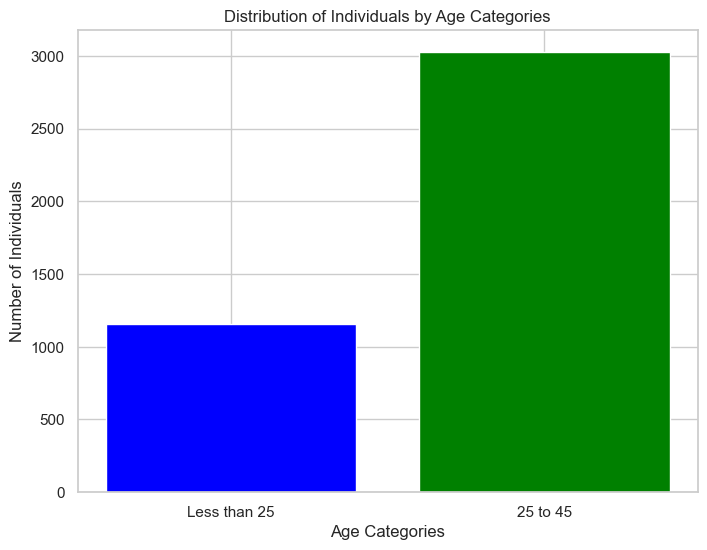

In [172]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'compas_data.features' contains the feature data and 'compas_data.feature_names' contains the column names
features_df = pd.DataFrame(compas_data.features, columns=compas_data.feature_names)

# Calculate the sum (or count) for 'Less than 25' and '25 to 45' age categories
age_less_25_count = features_df['age_cat=Less than 25'].sum()
age_25_to_45_count = features_df['age_cat=25 to 45'].sum()

# Creating a DataFrame for plotting
age_counts_df = pd.DataFrame({'Age Categories': ['Less than 25', '25 to 45'],
                              'Count': [age_less_25_count, age_25_to_45_count]})

# Plotting the graph
plt.figure(figsize=(8, 6))
plt.bar(age_counts_df['Age Categories'], age_counts_df['Count'], color=['blue', 'green'])
plt.title('Distribution of Individuals by Age Categories')
plt.xlabel('Age Categories')
plt.ylabel('Number of Individuals')
plt.show()


In [173]:
print(dataset_orig_test_pred.feature_names)


['sex', 'race', 'age_cat=25 to 45', 'age_cat=Greater than 45', 'age_cat=Less than 25', 'priors_count=0', 'priors_count=1 to 3', 'priors_count=More than 3', 'c_charge_degree=F', 'c_charge_degree=M']


## age_cat=Less than 25

In [174]:
# Filtering for under-25s
age_cat_index = compas_data.feature_names.index('age_cat=Less than 25')
under_25_indices = compas_data.features[:, age_cat_index] == 1
dataset_under_25 = compas_data.subset(under_25_indices)


dataset_under_25_train, dataset_under_25_test = dataset_under_25.split([0.5], shuffle=True)


RW_sex = Reweighing(unprivileged_groups=[{'sex': 0}], privileged_groups=[{'sex': 1}])
dataset_under_25_train_sex_rw = RW_sex.fit_transform(dataset_under_25_train)


RW_race = Reweighing(unprivileged_groups=[{'race': 0}], privileged_groups=[{'race': 1}])
dataset_under_25_train_race_rw = RW_race.fit_transform(dataset_under_25_train)


In [175]:

model_sex = LogisticRegression()
model_sex.fit(dataset_under_25_train_sex_rw.features, dataset_under_25_train_sex_rw.labels.ravel(),
              sample_weight=dataset_under_25_train_sex_rw.instance_weights)


model_race = LogisticRegression()
model_race.fit(dataset_under_25_train_race_rw.features, dataset_under_25_train_race_rw.labels.ravel(),
               sample_weight=dataset_under_25_train_race_rw.instance_weights)


dataset_under_25_test_sex_pred = dataset_under_25_test.copy()
dataset_under_25_test_race_pred = dataset_under_25_test.copy()

dataset_under_25_test_sex_pred.labels = model_sex.predict(dataset_under_25_test_sex_pred.features)
dataset_under_25_test_race_pred.labels = model_race.predict(dataset_under_25_test_race_pred.features)

# Calculation of metrics for sex and race on the test set
metric_test_sex = BinaryLabelDatasetMetric(dataset_under_25_test_sex_pred, 
                                           unprivileged_groups=[{'sex': 0}],
                                           privileged_groups=[{'sex': 1}])

metric_test_race = BinaryLabelDatasetMetric(dataset_under_25_test_race_pred, 
                                            unprivileged_groups=[{'race': 0}],
                                            privileged_groups=[{'race': 1}])

print("Metrics for Sex:")
print("Difference in mean results (Sex):", metric_test_sex.mean_difference())
print("Disparate Impact (Sex):", metric_test_sex.disparate_impact())

# print metric race
print("Race metric:")
print("Difference in average results (Race):", metric_test_race.mean_difference())
print("Impact Disparate (Race):", metric_test_race.disparate_impact())


Metrics for Sex:
Difference in mean results (Sex): 0.12265018289939555
Disparate Impact (Sex): 1.477459640572647
Race metric:
Difference in average results (Race): -0.03597926895799236
Impact Disparate (Race): 0.9164925609370054


For sex, the metrics showed a clear bias in favour of the privileged group, with a significant
positive difference in mean scores and a disparate impact greater than 1. This indicates that the
privileged group based on sex receives more favourable treatment by the model. In contrast, the
race measures revealed a slightly unfavourable bias towards the non-privileged group, as evidenced
by the negative difference in mean scores and a disparate impact of slightly less than 1, although
these biases were less pronounced than those related to sex

In [176]:



features_df = pd.DataFrame(dataset_under_25.features, columns=dataset_under_25.feature_names)


print(features_df['age_cat=Less than 25'].value_counts())


age_cat=Less than 25
1.0    1156
Name: count, dtype: int64


## age_cat=25 to 45

In [177]:
# Filtering for people over 25
age_cat_index = compas_data.feature_names.index('age_cat=25 to 45')
under_25_indices = compas_data.features[:, age_cat_index] == 1
dataset_under_25 = compas_data.subset(under_25_indices)

dataset_under_25_train, dataset_under_25_test = dataset_under_25.split([0.5], shuffle=True)

RW_sex = Reweighing(unprivileged_groups=[{'sex': 0}], privileged_groups=[{'sex': 1}])
dataset_under_25_train_sex_rw = RW_sex.fit_transform(dataset_under_25_train)

# 
RW_race = Reweighing(unprivileged_groups=[{'race': 0}], privileged_groups=[{'race': 1}])
dataset_under_25_train_race_rw = RW_race.fit_transform(dataset_under_25_train)



In [178]:

model_sex = LogisticRegression()
model_sex.fit(dataset_under_25_train_sex_rw.features, dataset_under_25_train_sex_rw.labels.ravel(),
              sample_weight=dataset_under_25_train_sex_rw.instance_weights)


model_race = LogisticRegression()
model_race.fit(dataset_under_25_train_race_rw.features, dataset_under_25_train_race_rw.labels.ravel(),
               sample_weight=dataset_under_25_train_race_rw.instance_weights)


dataset_under_25_test_sex_pred = dataset_under_25_test.copy()
dataset_under_25_test_race_pred = dataset_under_25_test.copy()

dataset_under_25_test_sex_pred.labels = model_sex.predict(dataset_under_25_test_sex_pred.features)
dataset_under_25_test_race_pred.labels = model_race.predict(dataset_under_25_test_race_pred.features)

#Calculation of metrics for sex and race on the test set
metric_test_sex = BinaryLabelDatasetMetric(dataset_under_25_test_sex_pred, 
                                           unprivileged_groups=[{'sex': 0}],
                                           privileged_groups=[{'sex': 1}])

metric_test_race = BinaryLabelDatasetMetric(dataset_under_25_test_race_pred, 
                                            unprivileged_groups=[{'race': 0}],
                                            privileged_groups=[{'race': 1}])

print("Metrics for Sex:")
print("Difference in mean results (Sex):", metric_test_sex.mean_difference())
print("Disparate Impact (Sex):", metric_test_sex.disparate_impact())

# print metric race
print("Race metric:")
print("Difference in average results (Race):", metric_test_race.mean_difference())
print("Impact Disparate (Race):", metric_test_race.disparate_impact())

Metrics for Sex:
Difference in mean results (Sex): -0.18625013570730642
Disparate Impact (Sex): 0.751937592180225
Race metric:
Difference in average results (Race): -0.2184205860843743
Impact Disparate (Race): 0.7034991576751835


These results indicate that, for the 25 to 45 age group, biases towards non-privileged groups are
more pronounced for both sex and race than for individuals under 25. In particular, the racial bias
is more pronounced in this age group. This suggests that age factors interact with sex and race in a
significant way, influencing how biases manifest themselves in the model’s predictions.
These observations illustrate the importance of an intersectional approach to the analysis of
algorithmic fairness. They highlight the need to examine not only each protected attribute individ-
ually but also to understand how these attributes interact across different age groups. Such in-depth
analysis is crucial to developing effective bias mitigation strategies, tailored to the specificities of
each demographic sub-group

## age_cat=Greater than 45

In [179]:

age_cat_index = compas_data.feature_names.index('age_cat=Greater than 45')
under_25_indices = compas_data.features[:, age_cat_index] == 1
dataset_under_25 = compas_data.subset(under_25_indices)


dataset_under_25_train, dataset_under_25_test = dataset_under_25.split([0.5], shuffle=True)


RW_sex = Reweighing(unprivileged_groups=[{'sex': 0}], privileged_groups=[{'sex': 1}])
dataset_under_25_train_sex_rw = RW_sex.fit_transform(dataset_under_25_train)

# 
RW_race = Reweighing(unprivileged_groups=[{'race': 0}], privileged_groups=[{'race': 1}])
dataset_under_25_train_race_rw = RW_race.fit_transform(dataset_under_25_train)



In [180]:

model_sex = LogisticRegression()
model_sex.fit(dataset_under_25_train_sex_rw.features, dataset_under_25_train_sex_rw.labels.ravel(),
              sample_weight=dataset_under_25_train_sex_rw.instance_weights)

# simple Model for race
model_race = LogisticRegression()
model_race.fit(dataset_under_25_train_race_rw.features, dataset_under_25_train_race_rw.labels.ravel(),
               sample_weight=dataset_under_25_train_race_rw.instance_weights)


dataset_under_25_test_sex_pred = dataset_under_25_test.copy()
dataset_under_25_test_race_pred = dataset_under_25_test.copy()

dataset_under_25_test_sex_pred.labels = model_sex.predict(dataset_under_25_test_sex_pred.features)
dataset_under_25_test_race_pred.labels = model_race.predict(dataset_under_25_test_race_pred.features)


metric_test_sex = BinaryLabelDatasetMetric(dataset_under_25_test_sex_pred, 
                                           unprivileged_groups=[{'sex': 0}],
                                           privileged_groups=[{'sex': 1}])

metric_test_race = BinaryLabelDatasetMetric(dataset_under_25_test_race_pred, 
                                            unprivileged_groups=[{'race': 0}],
                                            privileged_groups=[{'race': 1}])

print("Metrics for Sex:")
print("Difference in mean results (Sex):", metric_test_sex.mean_difference())
print("Disparate Impact (Sex):", metric_test_sex.disparate_impact())

# print metric race
print("Race metric:")
print("Difference in average results (Race):", metric_test_race.mean_difference())
print("Impact Disparate (Race):", metric_test_race.disparate_impact())

Metrics for Sex:
Difference in mean results (Sex): -0.0950726692662176
Disparate Impact (Sex): 0.8771978021978023
Race metric:
Difference in average results (Race): -0.14065984564855993
Impact Disparate (Race): 0.8251717707930855


In [181]:
dataset_orig = load_preproc_data_compas()
dataset_orig_df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

## the Multi-Dimensional Subset Scan (MDSS) method

In [182]:
import numpy as np
import pandas as pd

# Convert one-hot columns into category columns
age_cat = np.argmax(dataset_orig_df[['age_cat=Less than 25', 'age_cat=25 to 45', 'age_cat=Greater than 45']].values, axis=1).reshape(-1, 1)
priors_count = np.argmax(dataset_orig_df[['priors_count=0', 'priors_count=1 to 3', 'priors_count=More than 3']].values, axis=1).reshape(-1, 1)
c_charge_degree = np.argmax(dataset_orig_df[['c_charge_degree=M', 'c_charge_degree=F']].values, axis=1).reshape(-1, 1)

# creer new data set
features = np.concatenate((dataset_orig_df[['sex', 'race']].values, age_cat, priors_count, c_charge_degree, dataset_orig.labels), axis=1)
feature_names = ['sex', 'race', 'age_cat', 'priors_count', 'c_charge_degree']

# 
final_df = pd.DataFrame(features, columns=feature_names + ['two_year_recid'])
final_df

,sex,race,age_cat,priors_count,c_charge_degree,two_year_recid
0,0.0,0.0,1.0,0.0,1.0,1.0
1,0.0,0.0,0.0,2.0,1.0,1.0
2,0.0,1.0,1.0,2.0,1.0,1.0
3,1.0,1.0,1.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...
5273,0.0,0.0,1.0,0.0,0.0,1.0
5274,0.0,0.0,0.0,0.0,1.0,0.0
5275,0.0,0.0,0.0,0.0,1.0,0.0
5276,0.0,0.0,0.0,0.0,1.0,0.0


In [183]:

under_25 = final_df['age_cat'] == 0 # Individuals under 25 years old
caucasian = final_df['race'] == 1 # Caucasian individuals
african_american = final_df['race'] == 0 # African-American individuals

# Creation of subgroups
under_25_caucasian = final_df[under_25 & caucasian]
under_25_african_american = final_df[under_25 & african_american]

# Display the number of individuals in each subgroup
print("Number of individuals under 25 and caucasian:", len(under_25_caucasian))
print("Number of people under 25 who are African-American:", len(under_25_african_american))

# Display the first lines to check
print("\nOverview of individuals under 25 and Caucasian:")
print(under_25_caucasian.head())

print("\nPreview of under-25s who are African-American:")
print(under_25_african_american.head())



Number of individuals under 25 and caucasian: 347
Number of people under 25 who are African-American: 809

Overview of individuals under 25 and Caucasian:
    sex  race  age_cat  priors_count  c_charge_degree  two_year_recid
16  1.0   1.0      0.0           0.0              1.0             0.0
25  0.0   1.0      0.0           1.0              0.0             1.0
54  0.0   1.0      0.0           0.0              1.0             0.0
65  1.0   1.0      0.0           0.0              1.0             0.0
71  0.0   1.0      0.0           2.0              1.0             1.0

Preview of under-25s who are African-American:
    sex  race  age_cat  priors_count  c_charge_degree  two_year_recid
1   0.0   0.0      0.0           2.0              1.0             1.0
5   0.0   0.0      0.0           1.0              0.0             1.0
14  0.0   0.0      0.0           1.0              1.0             1.0
28  1.0   0.0      0.0           1.0              1.0             0.0
39  0.0   0.0      0.0     

In [184]:
print("column'under_25_caucasian':", under_25_caucasian.columns)
print("Column 'under_25_african_american':", under_25_african_american.columns)


column'under_25_caucasian': Index(['sex', 'race', 'age_cat', 'priors_count', 'c_charge_degree',
       'two_year_recid'],
      dtype='object')
Column 'under_25_african_american': Index(['sex', 'race', 'age_cat', 'priors_count', 'c_charge_degree',
       'two_year_recid'],
      dtype='object')


In [185]:
under_25_caucasian_dataset = BinaryLabelDataset(favorable_label=1, unfavorable_label=0,
                                                df=under_25_caucasian, label_names=['two_year_recid'],
                                                protected_attribute_names=['sex'])

under_25_african_american_dataset = BinaryLabelDataset(favorable_label=1, unfavorable_label=0,
                                                       df=under_25_african_american, label_names=['two_year_recid'],
                                                       protected_attribute_names=['sex'])


print("display data 'under_25_caucasian_dataset':")
print(under_25_caucasian_dataset.convert_to_dataframe()[0].head())

print("\ndisplay the data 'under_25_african_american_dataset':")
print(under_25_african_american_dataset.convert_to_dataframe()[0].head())


display data 'under_25_caucasian_dataset':
    sex  race  age_cat  priors_count  c_charge_degree  two_year_recid
16  1.0   1.0      0.0           0.0              1.0             0.0
25  0.0   1.0      0.0           1.0              0.0             1.0
54  0.0   1.0      0.0           0.0              1.0             0.0
65  1.0   1.0      0.0           0.0              1.0             0.0
71  0.0   1.0      0.0           2.0              1.0             1.0

display the data 'under_25_african_american_dataset':
    sex  race  age_cat  priors_count  c_charge_degree  two_year_recid
1   0.0   0.0      0.0           2.0              1.0             1.0
5   0.0   0.0      0.0           1.0              0.0             1.0
14  0.0   0.0      0.0           1.0              1.0             1.0
28  1.0   0.0      0.0           1.0              1.0             0.0
39  0.0   0.0      0.0           1.0              1.0             1.0


In [186]:
# Splitting the datasets
dataset_orig_train_caucasian, dataset_orig_test_caucasian = under_25_caucasian_dataset.split([0.7], shuffle=True, seed=0)
dataset_orig_train_african_american, dataset_orig_test_african_american = under_25_african_american_dataset.split([0.7], shuffle=True, seed=0)

In [187]:

female_group_caucasian= [{'sex': 1}]
male_group_caucasian= [{'sex': 0}]

female_group_african_american= [{'sex': 1}]
male_group_african_american= [{'sex': 0}]

metric_caucasian = BinaryLabelDatasetMetric(dataset_orig_train_caucasian,
                                            unprivileged_groups=female_group_caucasian,
                                            privileged_groups=male_group_caucasian)
print("train data :Caucasian group: Difference in mean outcomes  between unprivileged and privileged groups = %f" % metric_caucasian.mean_difference())

# compute score
metric_african_american = BinaryLabelDatasetMetric(dataset_orig_train_african_american,
                                                   unprivileged_groups=female_group_african_american,
                                                   privileged_groups=male_group_african_american)
print("train data :African-American group: Difference in mean outcomes  between unprivileged and privileged groups = %f" % metric_african_american.mean_difference())


train data :Caucasian group: Difference in mean outcomes  between unprivileged and privileged groups = -0.187780
train data :African-American group: Difference in mean outcomes  between unprivileged and privileged groups = -0.228220


 This indicates that African-American men 22% are more advantaged than African-American women in your dataset. 18% for Caucasian
 This confirms the existence of a gender bias in the data analysed, with a more marked impact among African-Americans.

In [188]:

female_group_caucasian= [{'sex': 1}]
male_group_caucasian= [{'sex': 0}]

female_group_african_american= [{'sex': 1}]
male_group_african_american= [{'sex': 0}]

metric_caucasian = BinaryLabelDatasetMetric(dataset_orig_test_caucasian,
                                            unprivileged_groups=female_group_caucasian,
                                            privileged_groups=male_group_caucasian)
print("test data :Caucasian group: Difference in mean outcomes  between unprivileged and privileged groups = %f" % metric_caucasian.mean_difference())

# score
metric_african_american = BinaryLabelDatasetMetric(dataset_orig_test_african_american,
                                                   unprivileged_groups=female_group_african_american,
                                                   privileged_groups=male_group_african_american)
print("test data :African-American group: Difference in mean outcomes  between unprivileged and privileged groups = %f" % metric_african_american.mean_difference())


test data :Caucasian group: Difference in mean outcomes  between unprivileged and privileged groups = -0.275073
test data :African-American group: Difference in mean outcomes  between unprivileged and privileged groups = -0.130172


## train a classifier for both , 
the model is likely to pick up this bias in the dataset

In [189]:
# For the caucasian group
clf_caucasian = LogisticRegression(solver='lbfgs', C=1.0, penalty='l2', random_state=0)
clf_caucasian.fit(dataset_orig_train_caucasian.features, dataset_orig_train_caucasian.labels.flatten())




LogisticRegression(random_state=0)

In [190]:
# For the African-American group
clf_african_american = LogisticRegression(solver='lbfgs', C=1.0, penalty='l2', random_state=0)
clf_african_american.fit(dataset_orig_train_african_american.features, dataset_orig_train_african_american.labels.flatten())


LogisticRegression(random_state=0)

# Probability prediction on the Caucasian test set

In [191]:

dataset_bias_test_prob_caucasian = clf_caucasian.predict_proba(dataset_orig_test_caucasian.features)[:, 0]

# 
df_caucasian = pd.DataFrame(dataset_orig_test_caucasian.features, columns=dataset_orig_test_caucasian.feature_names)
df_caucasian['observed'] = pd.Series(dataset_orig_test_caucasian.labels.flatten(), index=df_caucasian.index)
df_caucasian['probabilities'] = pd.Series(dataset_bias_test_prob_caucasian, index=df_caucasian.index)
df_caucasian.head()

,sex,race,age_cat,priors_count,c_charge_degree,observed,probabilities
0,0.0,1.0,0.0,0.0,1.0,1.0,0.564323
1,0.0,1.0,0.0,2.0,0.0,1.0,0.285311
2,0.0,1.0,0.0,1.0,1.0,1.0,0.416105
3,0.0,1.0,0.0,0.0,1.0,0.0,0.564323
4,0.0,1.0,0.0,1.0,1.0,1.0,0.416105


### Bias scoring caucasian group

In [192]:
# Copie 
dataset_bias_test_caucasian = dataset_orig_test_caucasian.copy()
dataset_bias_test_caucasian.scores = clf_caucasian.predict_proba(dataset_orig_test_caucasian.features)[:, 1]
dataset_bias_test_caucasian.labels = dataset_orig_test_caucasian.labels

test_df_caucasian = dataset_bias_test_caucasian.convert_to_dataframe()[0]
test_df_caucasian['model_not_recid'] = dataset_bias_test_caucasian.scores.flatten()
test_df_caucasian['observed_not_recid'] = 1 - test_df_caucasian['two_year_recid']  
test_df_caucasian


,sex,race,age_cat,priors_count,c_charge_degree,two_year_recid,model_not_recid,observed_not_recid
3284,0.0,1.0,0.0,0.0,1.0,1.0,0.435677,0.0
4477,0.0,1.0,0.0,2.0,0.0,1.0,0.714689,0.0
4153,0.0,1.0,0.0,1.0,1.0,1.0,0.583895,0.0
4835,0.0,1.0,0.0,0.0,1.0,0.0,0.435677,1.0
4385,0.0,1.0,0.0,1.0,1.0,1.0,0.583895,0.0
...,...,...,...,...,...,...,...,...
4797,0.0,1.0,0.0,0.0,0.0,0.0,0.431250,1.0
2965,1.0,1.0,0.0,1.0,0.0,0.0,0.416547,1.0
1696,0.0,1.0,0.0,1.0,0.0,1.0,0.579509,0.0
620,1.0,1.0,0.0,1.0,1.0,0.0,0.420934,1.0


In [193]:
# average for group female caucasian
test_df_caucasian[test_df_caucasian['sex'] == 1][['model_not_recid','observed_not_recid']].mean()  

model_not_recid       0.351998
observed_not_recid    0.730769
dtype: float64

Mean Model Prediction (Model Not Recid): 0.351998. This suggests that the model predicts that only about 35.2% of individuals in this Caucasian group under the age of 25 will not recidivate (since the favourable label is 1, therefore not recid).
Mean Actual Observations (Observed Not Recid): 0.730769. This indicates that, in reality, approximately 73.1% of individuals in this group did not reoffend.

## MDSS Classification Metric group_caucasian 
Now, we'll create an instance of the MDSS Classification Metric and assess the apriori defined privileged and unprivileged groups; female_group_caucasian and male_group_caucasian respectively.

In [194]:
mdss_classified_caucasian = MDSSClassificationMetric(dataset_orig_test_caucasian, dataset_bias_test_caucasian,
                                                     unprivileged_groups=female_group_caucasian,
                                                     privileged_groups=male_group_caucasian )

# score
homme_privileged_score_caucasian = mdss_classified_caucasian.score_groups(privileged=True)
homme_privileged_score_caucasian

-0.0

In [195]:
female_privileged_score_caucasian = mdss_classified_caucasian.score_groups(privileged=False)
female_privileged_score_caucasian

-0.0

**Preferred Men (Score of 0):** The absence of a detectable bias in favor of Caucasian men suggests that the model treats men and women relatively equivalently, at least according to the criteria analyzed by the MDSS.

**Non-Privileged Females (Score of 0):** Similarly, the absence of detectable bias against Caucasian women indicates that the model does not show inequitable treatment towards them compared to men.


the MDSS scores for both groups (men as privileged and women as unprivileged) are 0 in the Caucasian context, 
this suggests that, according to this specific metric, there is no significant bias detected by the model towards or against either sex in the Caucasian group.

# Probability prediction on the test africain-américain

In [196]:

dataset_bias_test_prob_african_american = clf_african_american.predict_proba(dataset_orig_test_african_american.features)[:, 0]

df_african_american = pd.DataFrame(dataset_orig_test_african_american.features, columns=dataset_orig_test_african_american.feature_names)
df_african_american['observed'] = pd.Series(dataset_orig_test_african_american.labels.flatten(), index=df_african_american.index)
df_african_american['probabilities'] = pd.Series(dataset_bias_test_prob_african_american, index=df_african_american.index)
df_african_american.head()

,sex,race,age_cat,priors_count,c_charge_degree,observed,probabilities
0,0.0,0.0,0.0,1.0,0.0,0.0,0.316611
1,0.0,0.0,0.0,1.0,1.0,0.0,0.292806
2,0.0,0.0,0.0,0.0,1.0,0.0,0.509501
3,0.0,0.0,0.0,0.0,1.0,1.0,0.509501
4,1.0,0.0,0.0,1.0,0.0,1.0,0.487783


In [197]:

dataset_bias_test_african_american = dataset_orig_test_african_american.copy()

dataset_bias_test_african_american.scores = clf_african_american.predict_proba(dataset_orig_test_african_american.features)[:, 1]
dataset_bias_test_african_american.labels = dataset_orig_test_african_american.labels

test_df_african_american = dataset_bias_test_african_american.convert_to_dataframe()[0]

# add new column for observation
test_df_african_american['model_not_recid'] = dataset_bias_test_african_american.scores.flatten()
test_df_african_american['observed_not_recid'] = 1 - test_df_african_american['two_year_recid']  

test_df_african_american

,sex,race,age_cat,priors_count,c_charge_degree,two_year_recid,model_not_recid,observed_not_recid
3416,0.0,0.0,0.0,1.0,0.0,0.0,0.683389,1.0
4318,0.0,0.0,0.0,1.0,1.0,0.0,0.707194,1.0
5126,0.0,0.0,0.0,0.0,1.0,0.0,0.490499,1.0
1138,0.0,0.0,0.0,0.0,1.0,1.0,0.490499,0.0
1090,1.0,0.0,0.0,1.0,0.0,1.0,0.512217,0.0
...,...,...,...,...,...,...,...,...
4992,0.0,0.0,0.0,1.0,0.0,0.0,0.683389,1.0
1273,0.0,0.0,0.0,0.0,1.0,0.0,0.490499,1.0
4142,0.0,0.0,0.0,2.0,1.0,1.0,0.858343,0.0
3714,1.0,0.0,0.0,1.0,1.0,1.0,0.540232,0.0


In [198]:
# score
test_df_african_american[test_df_african_american['sex'] == 1][['model_not_recid','observed_not_recid']].mean()  


model_not_recid       0.42175
observed_not_recid    0.47500
dtype: float64

Mean Model Prediction (Model Not Recid): 0.42175. This means that the model predicts that 42.175% of individuals in this group will not recidivate (favourable label 1).

Observed Not Recid: 0.47500. This indicates that, in reality, 47.5% of the individuals in this group did not reoffen

The difference between the model's predictions and actual observations is less pronounced than in the Caucasian group. Here, the model slightly underestimates the probability of African-American individuals not reoffending, but the difference is relatively small (around 4.725%).d.

## MDSS Classification Metric group_african_american


In [199]:
mdss_classified_african_american = MDSSClassificationMetric(dataset_orig_test_african_american, dataset_bias_test_african_american,
                                                             unprivileged_groups=female_group_african_american,
                                                             privileged_groups= male_group_african_american )

# 
homme_privileged_score_african_american = mdss_classified_african_american.score_groups(privileged=True)
homme_privileged_score_african_american

-0.0

A score: -0.0 suggests that there is no detectable difference in the treatment of men.

In [200]:
femele_unprivileged_score = mdss_classified_african_american.score_groups(privileged=False)
femele_unprivileged_score

0.9194

The score of 0.9194 for African-American women as a non-privileged group, obtained using the MDSS metric, indicates a very different situation from that observed for African-American men.

Interpretation of the Score for African-American Women (Non-Privileged) :

A score of 0.9194 is relatively high and suggests that, according to the MDSS, there is a significant bias against African-American women in the dataset.
This score indicates that the model may be underestimating the favourable label for African-American women relative to their actual distribution in the data.
In terms of bias, this could mean that the model is less fair to African-American women compared to African-American men.

The juxtaposition of this high score for women with the score of -0.0 for men suggests that there is a notable disparity in the way the model treats African-American men and women.

## conclusion
Based on analyses carried out using the MDSS (Multi-Dimensional Subset Scan) metric on the two specific groups - Caucasians and African-Americans - under the age of 25, here is a conclusion:

1. **Caucasian group:**

   - MDSS scores are 0 for both males and females, indicating that there is no significant bias detected by the model towards or against either sex in this group.
   - This lack of bias suggests that the model treats Caucasian men and women under the age of 25 relatively equally with respect to the criteria analyzed by the MDSS.

2. **African-American group:**

   - For African-American men, the MDSS score is also 0, indicating no significant bias in their favor.
   - On the other hand, for African-American women, the MDSS score is relatively high (0.9194), suggesting a significant bias against them. This bias indicates that the model may under-estimate the probability of a favorable label (non-recurrence) for African-American women compared with men.
